In [1]:
import pandas as pd
import re
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

In [2]:
# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

In [3]:
# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

In [4]:
# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [5]:
#date to date format and sorting with it

data['date'] = pd.to_datetime(data['date'])

In [6]:
def convert_utc_to_cet(df, date_column='date'):
    """
    Convert UTC timestamps to Central European Time (CET/CEST) with proper DST handling
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the date column
    date_column (str): Name of the column containing UTC timestamps
    
    Returns:
    pd.DataFrame: DataFrame with converted timestamps
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df


In [7]:
data = convert_utc_to_cet(data)

In [8]:
# Define the regex pattern
pattern = r"\b(?:Cheer|Corgo|cheerwhal|uni|ShowLove|Party|SeemsGood|Pride|Kappa|FrankerZ|HeyGuys|DansGame|TriHard|Kreygasm|4Head|SwiftRage|NotLikeThis|FailFish|VoHiYo|PJSalt|MrDestructoid|bday|RIPCheer|Shamrock)(\d+)\b"

# Apply the filter
filtered_data = data[data["message"].str.extract(pattern).notna().any(axis=1)]

In [9]:

# Display the filtered DataFrame
filtered_data.head(10)

,date,user,message,stream
12818,2024-05-06 17:18:54+02:00,walnutNESS,Cheer100 what are you gonna do on the stream t...,5
12839,2024-05-06 17:20:10+02:00,walnutNESS,Cheer100 sry I missed it what are you doing on...,5
15177,2024-05-06 19:25:09+02:00,Wii_Gii,Cheer100 donating to help finance my favorite ...,5
21005,2024-05-09 21:22:46+02:00,SUP_P1,Cheer100 Hi sis,7
21934,2024-05-10 18:18:38+02:00,Martin_Gales,Cheer10 no,8
29530,2024-05-13 18:53:04+02:00,Martin_Gales,Cheer10,11
29563,2024-05-13 19:00:08+02:00,enseje,Cheer10 Cheer10,11
41385,2024-05-18 21:59:52+02:00,FrostSnail,Cheer100 Spettekaka Kappa,15
42323,2024-05-19 17:46:43+02:00,xXGenly_Top_AwpXx,Cheer10,16
42515,2024-05-19 18:16:55+02:00,xXGenly_Top_AwpXx,Cheer90,16


In [10]:
# Function to extract and sum numbers correctly
def extract_and_sum(message):
    # Find all matches - the tuple contains just the captured number
    matches = re.findall(pattern, message)
    
    # Convert matches to integers and sum
    numbers = [int(num) for num in matches]
    return sum(numbers) if numbers else 0

# Apply the function to create a new column
data["cheer_sum"] = data["message"].apply(extract_and_sum)

# Filter the DataFrame to keep only rows where the sum is greater than 0
filtered_data2 = data[data["cheer_sum"] > 0]





In [11]:
# Display the result
filtered_data2.head(10)

,date,user,message,stream,cheer_sum
12818,2024-05-06 17:18:54+02:00,walnutNESS,Cheer100 what are you gonna do on the stream t...,5,100
12839,2024-05-06 17:20:10+02:00,walnutNESS,Cheer100 sry I missed it what are you doing on...,5,100
15177,2024-05-06 19:25:09+02:00,Wii_Gii,Cheer100 donating to help finance my favorite ...,5,100
21005,2024-05-09 21:22:46+02:00,SUP_P1,Cheer100 Hi sis,7,100
21934,2024-05-10 18:18:38+02:00,Martin_Gales,Cheer10 no,8,10
29530,2024-05-13 18:53:04+02:00,Martin_Gales,Cheer10,11,10
29563,2024-05-13 19:00:08+02:00,enseje,Cheer10 Cheer10,11,20
41385,2024-05-18 21:59:52+02:00,FrostSnail,Cheer100 Spettekaka Kappa,15,100
42323,2024-05-19 17:46:43+02:00,xXGenly_Top_AwpXx,Cheer10,16,10
42515,2024-05-19 18:16:55+02:00,xXGenly_Top_AwpXx,Cheer90,16,90


In [12]:
# Function to extract the second-to-last word if the user is 'SoundAlerts'
def extract_bits(msg):
    words = msg.split()
    return int(words[-2]) if len(words) > 1 and words[-2].isdigit() else 0

# Apply function only to 'SoundAlerts' users
data["Bits"] = data.apply(lambda row: extract_bits(row["message"]) if row["user"] == "SoundAlerts" else 0, axis=1)

In [13]:
# Group by stream and sum Bits and Cheer_Sum separately
bits_per_stream = data.groupby("stream")["Bits"].sum().reset_index()
cheer_per_stream = data.groupby("stream")["cheer_sum"].sum().reset_index()

In [14]:
bits_per_stream.tail(10)

,stream,Bits
400,400,0
401,401,0
402,402,450
403,403,0
404,404,0
405,405,0
406,406,0
407,407,0
408,408,0
409,409,0


In [15]:
cheer_per_stream.tail(10)

,stream,cheer_sum
400,400,0
401,401,0
402,402,210
403,403,0
404,404,110
405,405,0
406,406,495
407,407,2010
408,408,310
409,409,5000


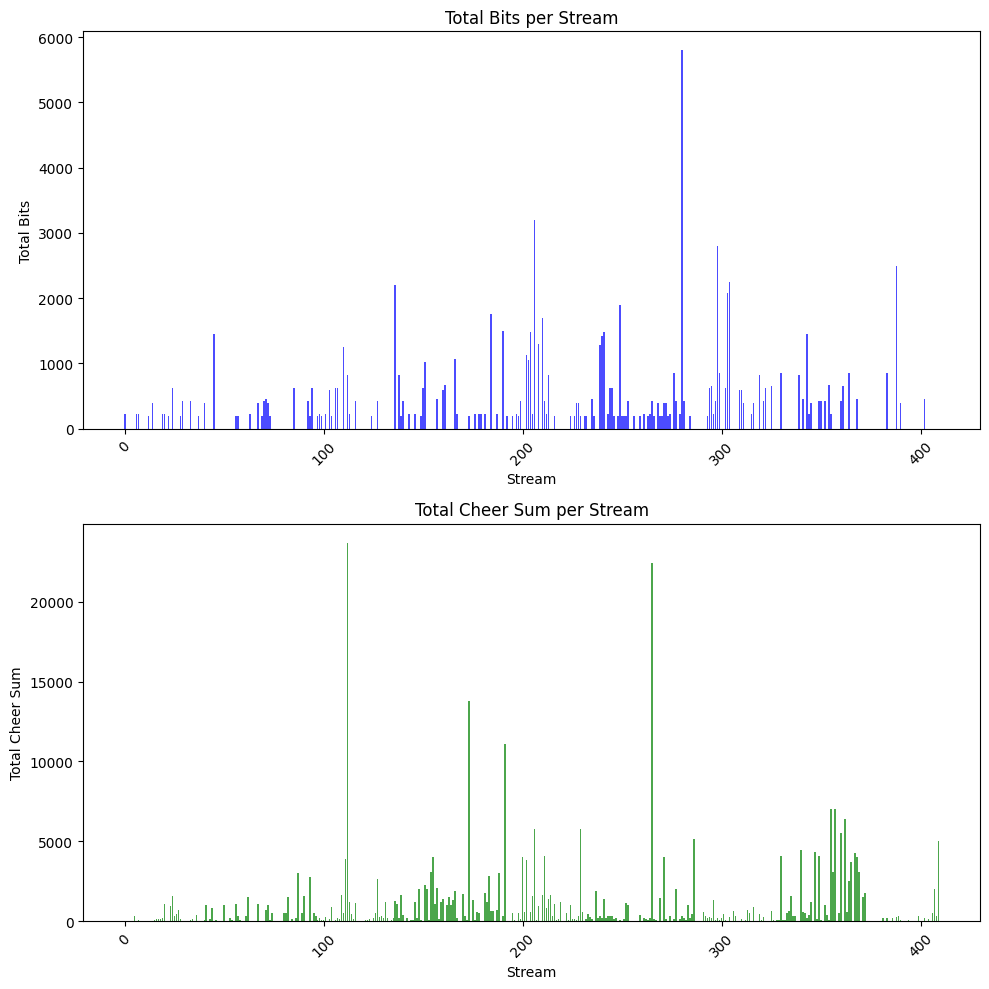

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot Bits per stream
axes[0].bar(bits_per_stream["stream"], bits_per_stream["Bits"], color="blue", alpha=0.7)
axes[0].set_title("Total Bits per Stream")
axes[0].set_xlabel("Stream")
axes[0].set_ylabel("Total Bits")
axes[0].tick_params(axis="x", rotation=45)

# Plot Cheer Sum per stream
axes[1].bar(cheer_per_stream["stream"], cheer_per_stream["cheer_sum"], color="green", alpha=0.7)
axes[1].set_title("Total Cheer Sum per Stream")
axes[1].set_xlabel("Stream")
axes[1].set_ylabel("Total Cheer Sum")
axes[1].tick_params(axis="x", rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()